In [410]:
import numpy as np
import sklearn as sk
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna

## Load Data

In [411]:
pd.set_option('display.max_columns', None)

In [412]:
df_test = pd.read_csv('C:/Users/Edward.Moradian/OneDrive - Microsoft/Desktop/Home/Practice/kaggle/kicked/test.csv')

In [413]:
df_training = pd.read_csv('C:/Users/Edward.Moradian/OneDrive - Microsoft/Desktop/Home/Practice/kaggle/kicked/training.csv')

In [414]:
df_training

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72978,73010,1,12/2/2009,ADESA,2001,8,MERCURY,SABLE,GS,4D SEDAN GS,BLACK,AUTO,1.0,Alloy,45234,AMERICAN,MEDIUM,FORD,1996.0,2993.0,2656.0,3732.0,2190.0,3055.0,4836.0,5937.0,NaN,NaN,18111,30212,GA,4200.0,0,993
72979,73011,0,12/2/2009,ADESA,2007,2,CHEVROLET,MALIBU 4C,LS,4D SEDAN LS,SILVER,AUTO,NaN,NaN,71759,AMERICAN,MEDIUM,GM,6418.0,7325.0,7431.0,8411.0,6785.0,8132.0,10151.0,11652.0,NaN,NaN,18881,30212,GA,6200.0,0,1038
72980,73012,0,12/2/2009,ADESA,2005,4,JEEP,GRAND CHEROKEE 2WD V,Lar,4D WAGON LAREDO,SILVER,AUTO,1.0,Alloy,88500,AMERICAN,MEDIUM SUV,CHRYSLER,8545.0,9959.0,9729.0,11256.0,8375.0,9802.0,11831.0,14402.0,NaN,NaN,18111,30212,GA,8200.0,0,1893
72981,73013,0,12/2/2009,ADESA,2006,3,CHEVROLET,IMPALA,LS,4D SEDAN LS,WHITE,AUTO,1.0,Alloy,79554,AMERICAN,LARGE,GM,6420.0,7604.0,7434.0,8712.0,6590.0,7684.0,10099.0,11228.0,NaN,NaN,18881,30212,GA,7000.0,0,1974


In [415]:
df_training.dtypes

RefId                                  int64
IsBadBuy                               int64
PurchDate                             object
Auction                               object
VehYear                                int64
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
SubModel                              object
Color                                 object
Transmission                          object
WheelTypeID                          float64
WheelType                             object
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrent

In [416]:
df_training['IsBadBuy'] = df_training['IsBadBuy'].astype('str')
df_training['RefId'] = df_training['RefId'].astype('str')
df_training['WheelTypeID'] = df_training['WheelTypeID'].astype('str')
df_training['BYRNO'] = df_training['BYRNO'].astype('str')
df_training['VNZIP1'] = df_training['VNZIP1'].astype('str')
df_training['IsOnlineSale'] = df_training['IsOnlineSale'].astype('str')


In [417]:
df_training['IsBadBuy'].unique()

array(['0', '1'], dtype=object)

In [418]:
df_training.loc[df_training.loc[:,'IsBadBuy'].isna(),'IsBadBuy'] = None

In [419]:
df_training.loc[df_training['IsBadBuy'].isna(),'IsBadBuy']

Series([], Name: IsBadBuy, dtype: object)

## Exploratory Data Analysis

In [420]:
df_training['IsBadBuy'].value_counts(dropna=False)

0    64007
1     8976
Name: IsBadBuy, dtype: int64

In [421]:
df_training['IsBadBuy'].value_counts(normalize=True,dropna=False)

0    0.877012
1    0.122988
Name: IsBadBuy, dtype: float64

Majority of Buys are a good buy.  BadBuy is not very low frequency to be an anomaly.

<AxesSubplot:ylabel='IsBadBuy'>

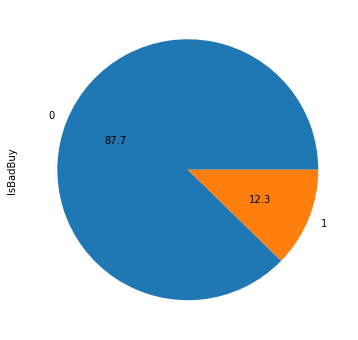

In [422]:
df_training['IsBadBuy'].value_counts(normalize=True,dropna=False).plot(kind='pie',autopct='%.1f',figsize=(8,6))

In [423]:
df_training.columns.sort_values()

Index(['AUCGUART', 'Auction', 'BYRNO', 'Color', 'IsBadBuy', 'IsOnlineSale',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'Make',
       'Model', 'Nationality', 'PRIMEUNIT', 'PurchDate', 'RefId', 'Size',
       'SubModel', 'TopThreeAmericanName', 'Transmission', 'Trim', 'VNST',
       'VNZIP1', 'VehBCost', 'VehOdo', 'VehYear', 'VehicleAge', 'WarrantyCost',
       'WheelType', 'WheelTypeID'],
      dtype='object')

In [424]:
df_training.dtypes.items()

In [425]:
dim_cols = df_training.loc[:,df_training.dtypes == 'object'].columns
fact_cols = df_training.loc[:,df_training.dtypes != 'object'].columns

In [426]:
fact_cols

Index(['VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost'],
      dtype='object')

In [427]:
dim_cols

Index(['RefId', 'IsBadBuy', 'PurchDate', 'Auction', 'Make', 'Model', 'Trim',
       'SubModel', 'Color', 'Transmission', 'WheelTypeID', 'WheelType',
       'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART',
       'BYRNO', 'VNZIP1', 'VNST', 'IsOnlineSale'],
      dtype='object')

Vehicle Age for bad buys is slighlty older by about 1 year. Vehicle Cost has more extreme value outliers for bad buys. and a higher mean. Warranty costs are lower for bad buys.

In [428]:
df_training.loc[df_training.loc[:,'IsBadBuy'] == '1',:].describe()

,VehYear,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,WarrantyCost
count,8976.000000,8976.000000,8976.000000,8975.000000,8975.000000,8975.000000,8975.000000,8944.000000,8944.000000,8944.000000,8944.000000,8976.000000,8976.000000
mean,2004.608512,4.940954,74714.148173,5410.697604,6625.218942,7760.293148,9094.547744,5423.031194,6644.840452,7918.462545,9259.641883,6259.274157,1360.246546
std,1.776551,1.765302,14150.973362,2648.702459,2941.060152,3346.761225,3615.830060,2592.306354,2875.176655,3268.131003,3519.830641,2078.955281,679.894543
min,2001.000000,1.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,462.000000
25%,2003.000000,4.000000,65978.000000,3475.000000,4516.000000,5401.000000,6595.000000,3487.000000,4554.000000,5600.750000,6787.750000,4765.000000,909.000000
50%,2005.000000,5.000000,76545.500000,5005.000000,6203.000000,7453.000000,8826.000000,5015.500000,6211.000000,7623.000000,8984.000000,6000.000000,1243.000000
75%,2006.000000,6.000000,84942.000000,6993.000000,8276.500000,9884.000000,11322.500000,6960.000000,8262.250000,9961.750000,11430.000000,7505.000000,1647.250000
max,2009.000000,9.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,45469.000000,6492.000000


In [429]:
df_training.loc[df_training.loc[:,'IsBadBuy'] == '0',:].describe() - df_training.loc[df_training.loc[:,'IsBadBuy'] == '1',:].describe()

,VehYear,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,WarrantyCost
count,55031.000000,55031.000000,55031.000000,55015.000000,55015.000000,55015.000000,55015.000000,54780.000000,54780.000000,54780.000000,54780.000000,55031.000000,55031.000000
mean,0.837549,-0.871493,-3664.887811,818.945308,853.387294,840.073769,862.467618,808.569019,850.524152,977.581866,1010.062200,537.803274,-95.398373
std,-0.076927,-0.088277,430.524507,-231.020839,-267.318565,-231.994948,-277.212261,-197.423832,-233.292617,-222.374871,-259.233215,-369.585752,-94.256971
min,0.000000,-1.000000,543.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1399.000000,0.000000
25%,1.000000,-1.000000,-4675.500000,948.250000,1071.000000,1015.000000,1016.000000,927.000000,1023.000000,1083.250000,1170.250000,760.000000,-75.000000
50%,1.000000,-1.000000,-3665.500000,1235.500000,1247.000000,1117.000000,1094.000000,1191.500000,1239.000000,1266.000000,1284.000000,800.000000,-88.000000
75%,1.000000,-1.000000,-2931.500000,848.000000,798.500000,841.000000,855.500000,844.000000,821.750000,1061.500000,971.000000,435.000000,-34.250000
max,1.000000,0.000000,-2100.000000,-15395.000000,-12844.000000,-14350.000000,-13969.000000,-13885.000000,-11012.000000,-14996.000000,-12647.000000,-29124.000000,1006.000000


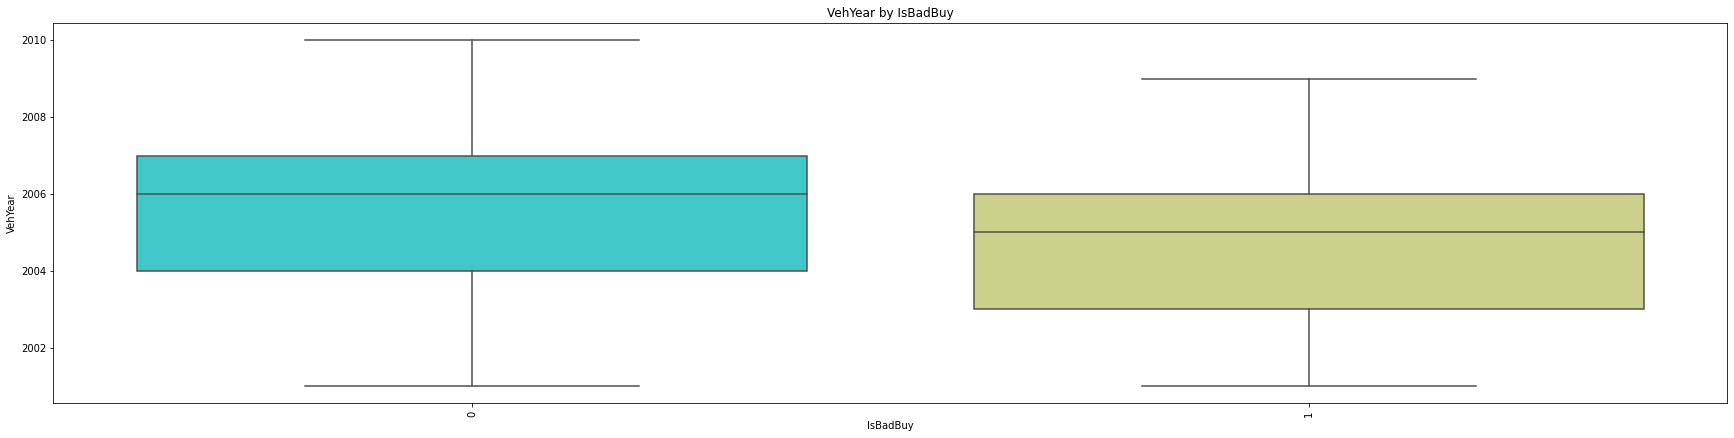

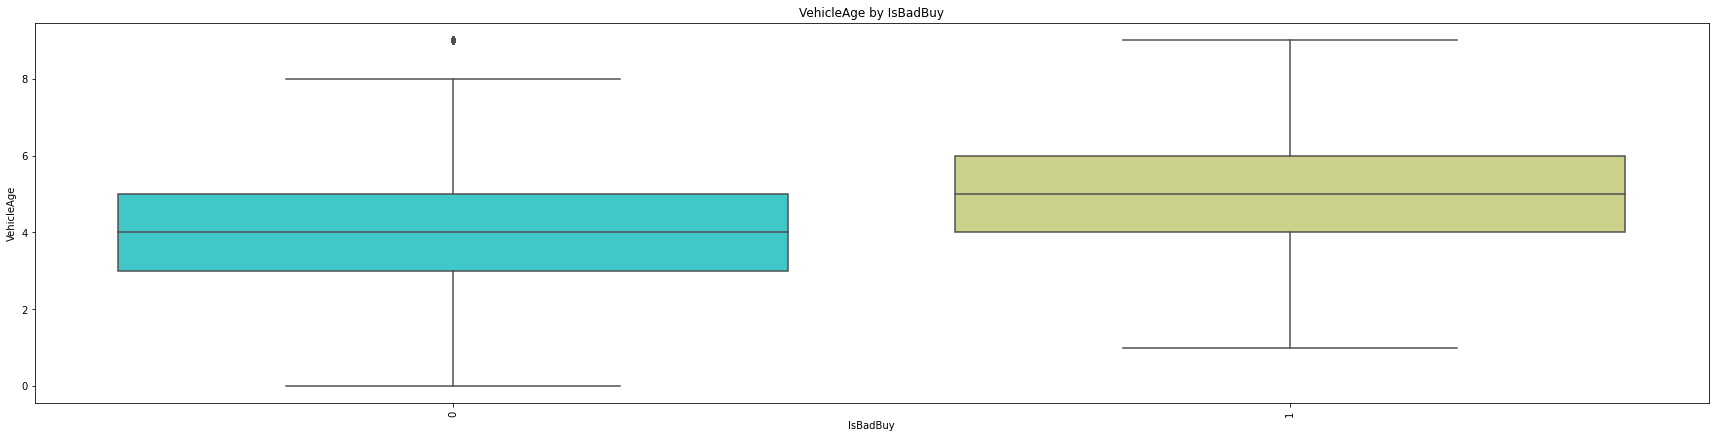

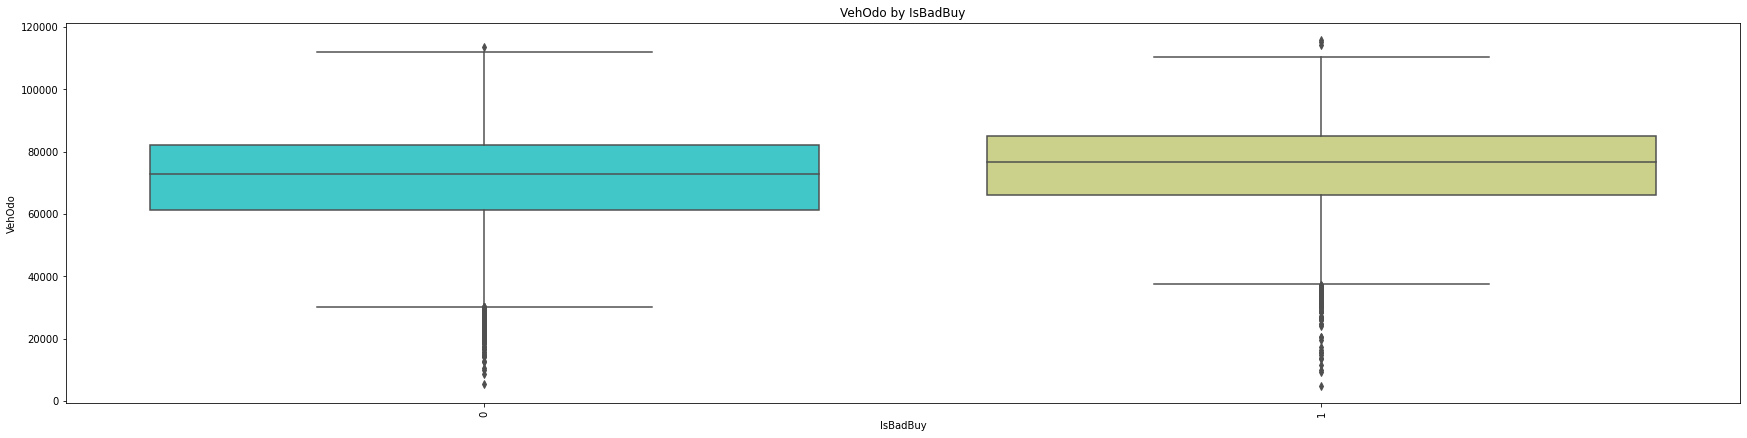

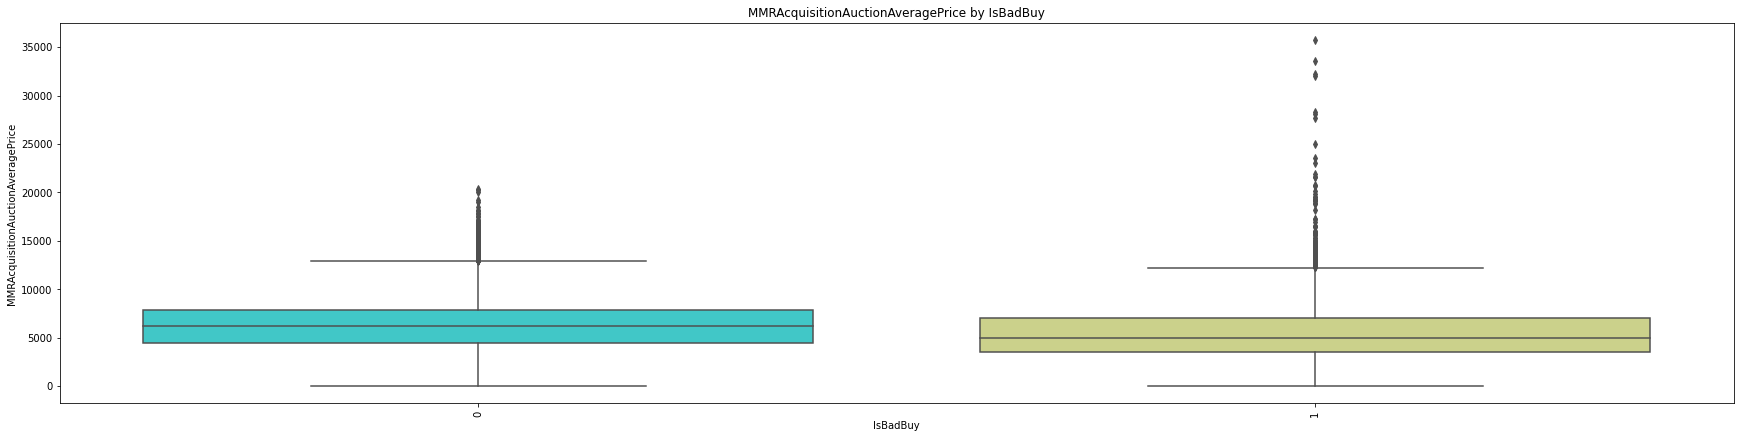

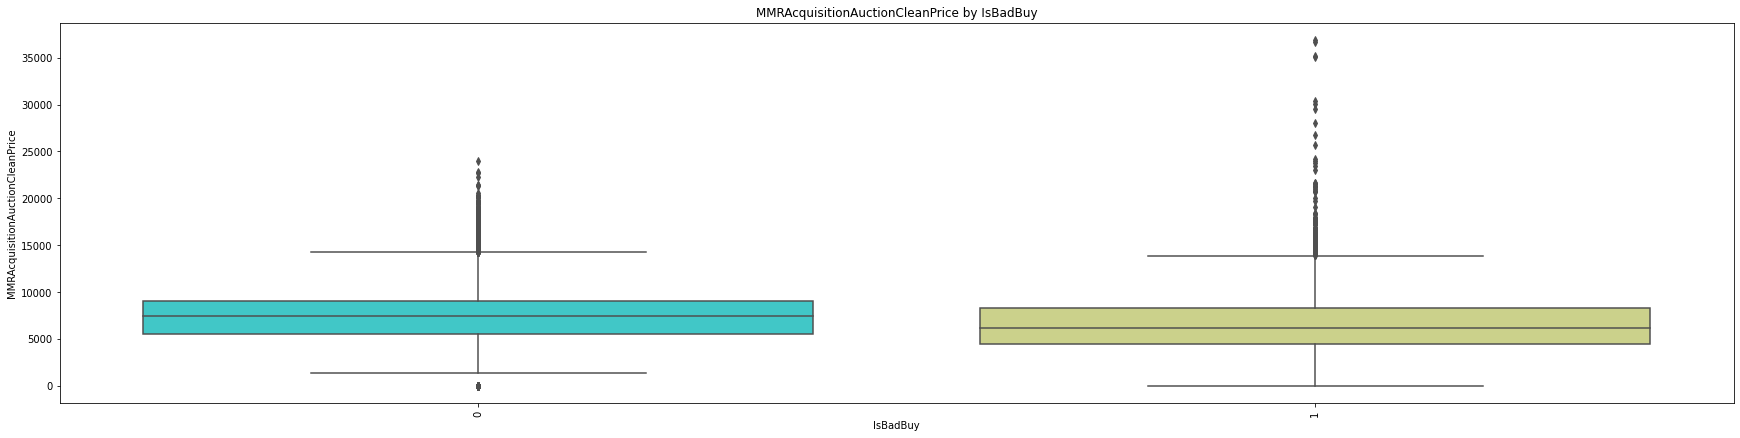

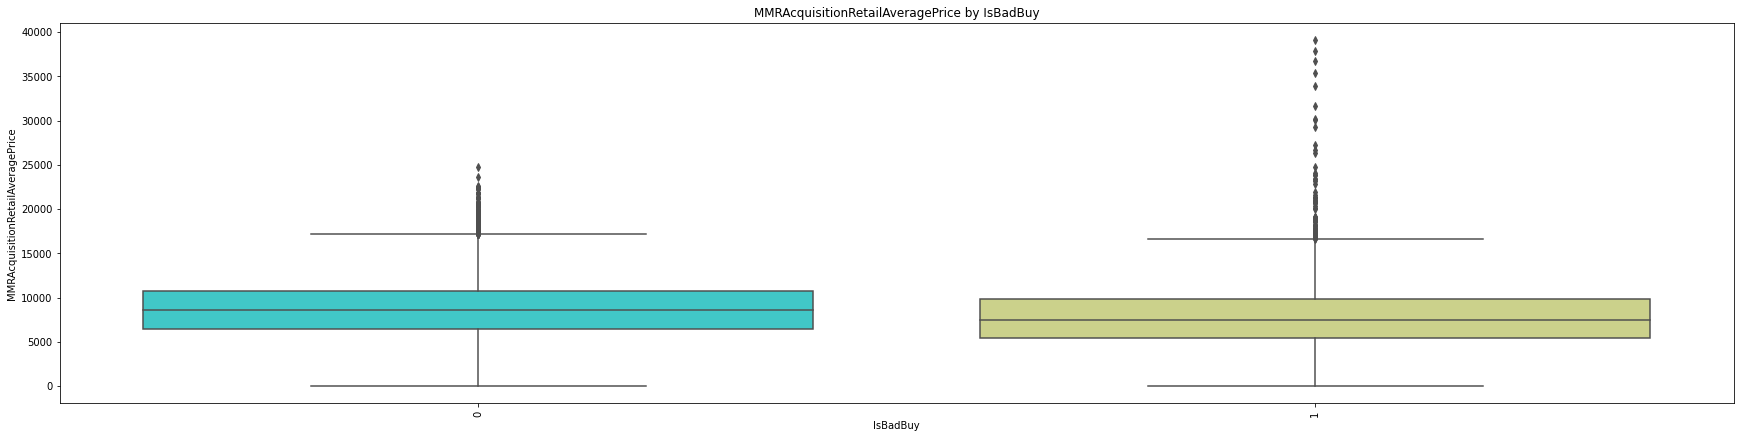

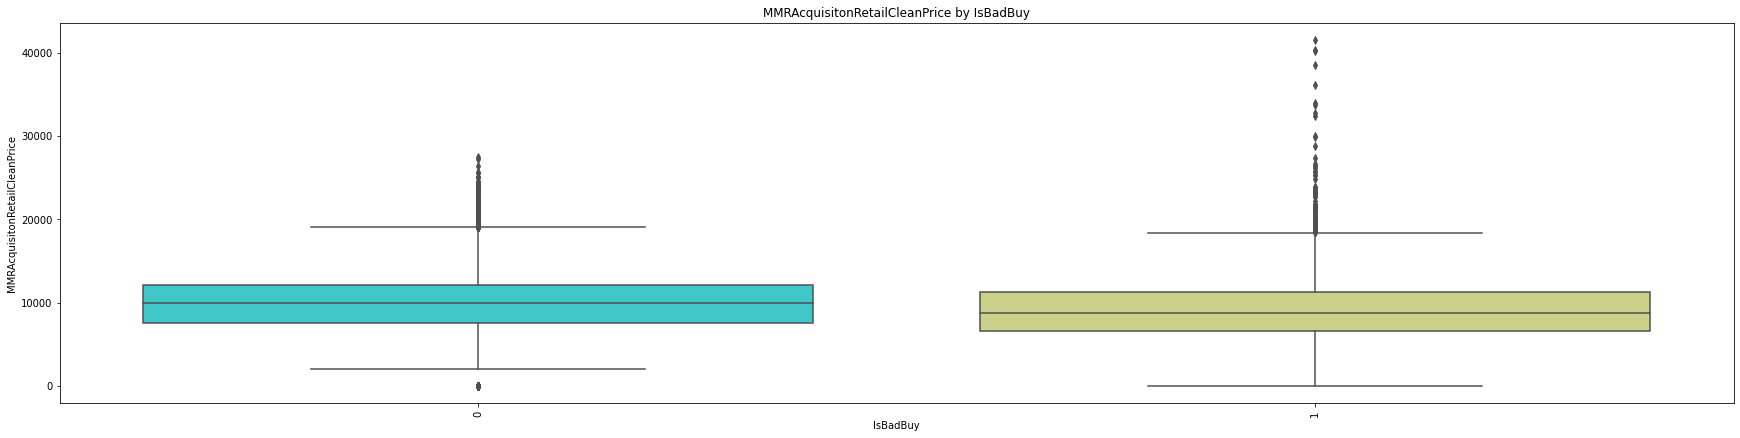

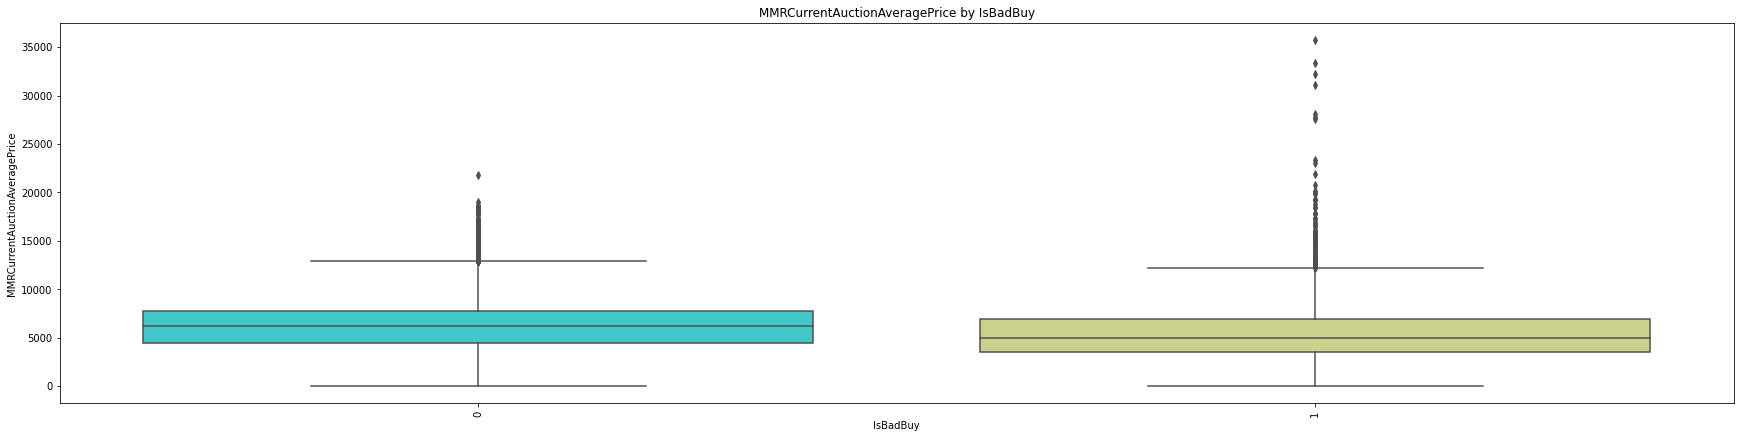

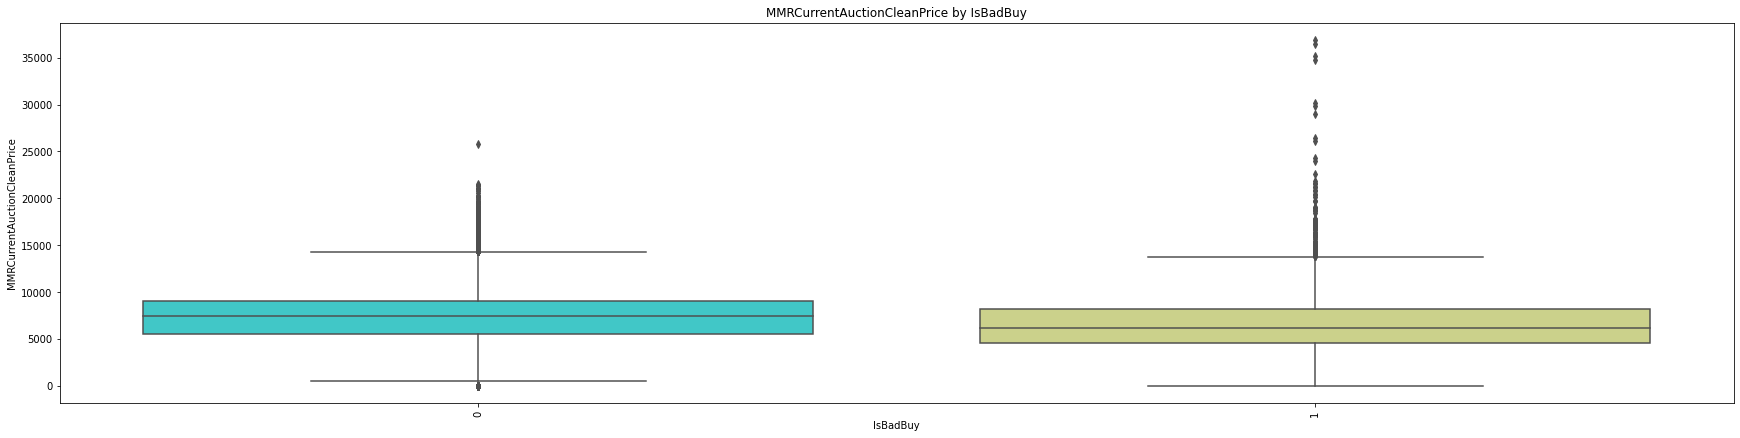

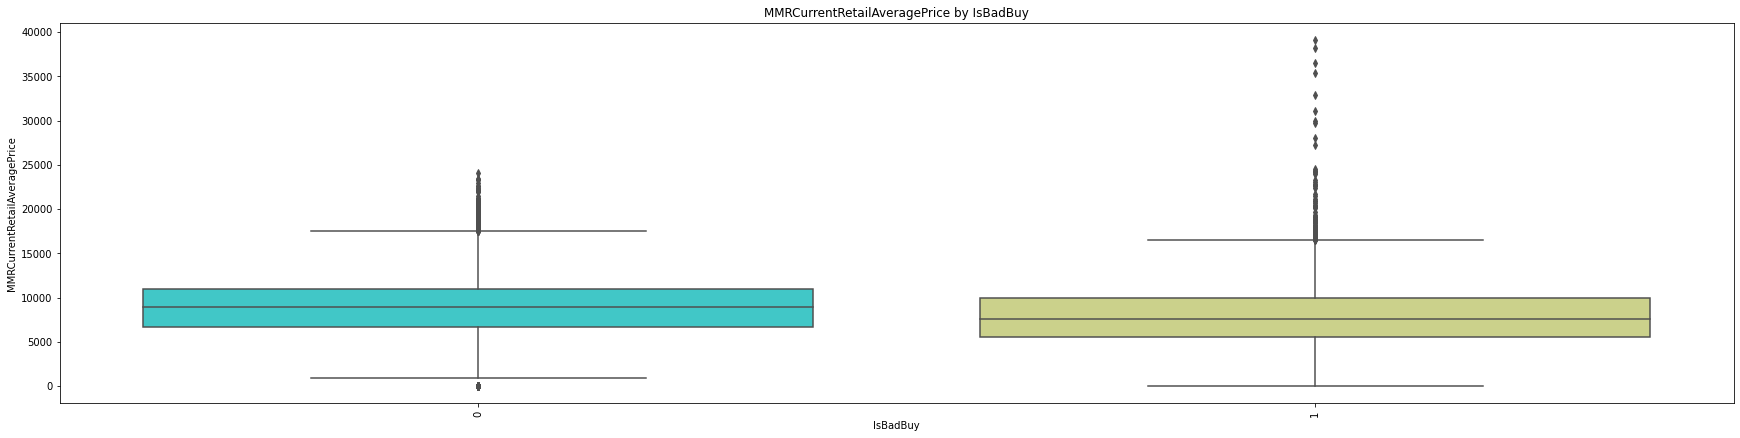

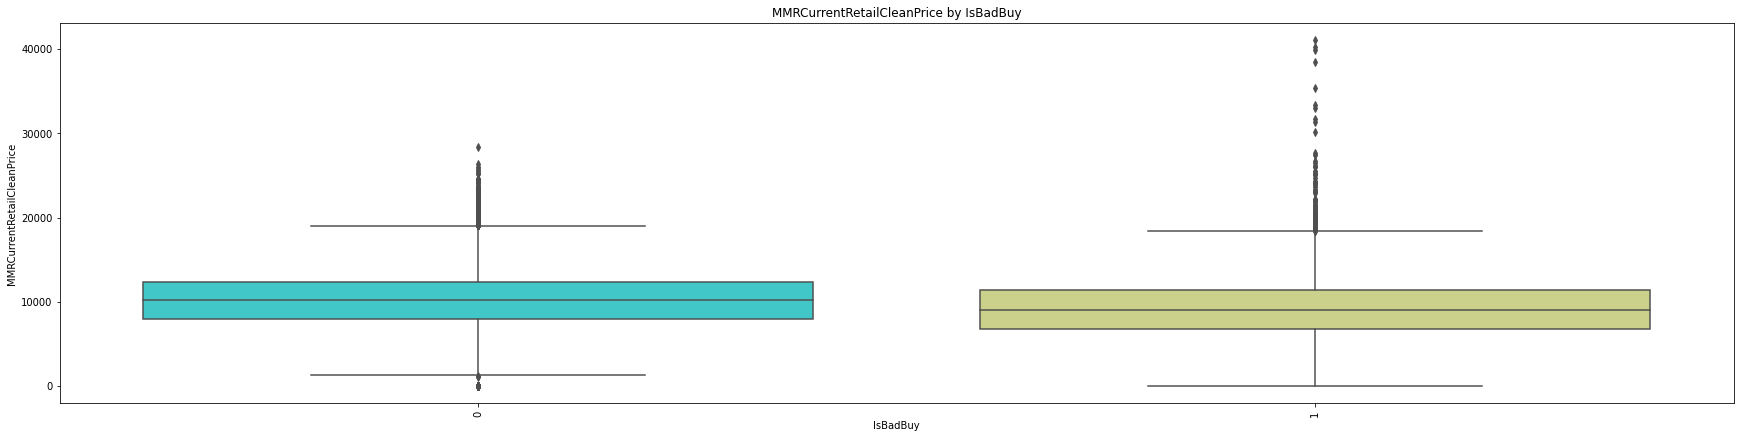

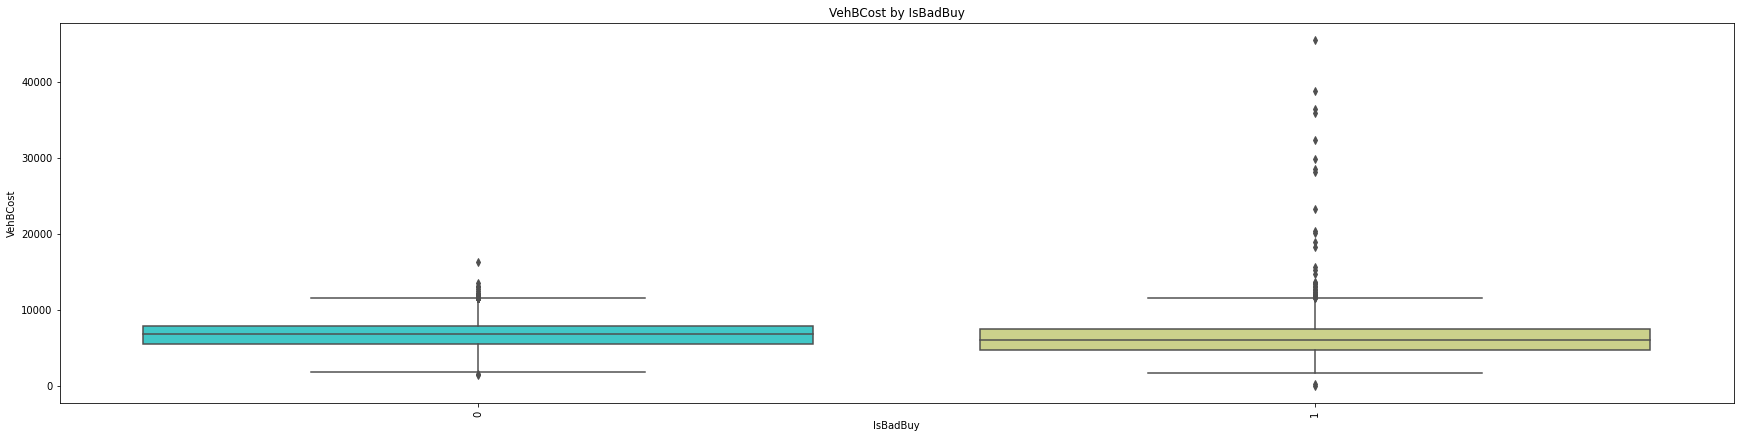

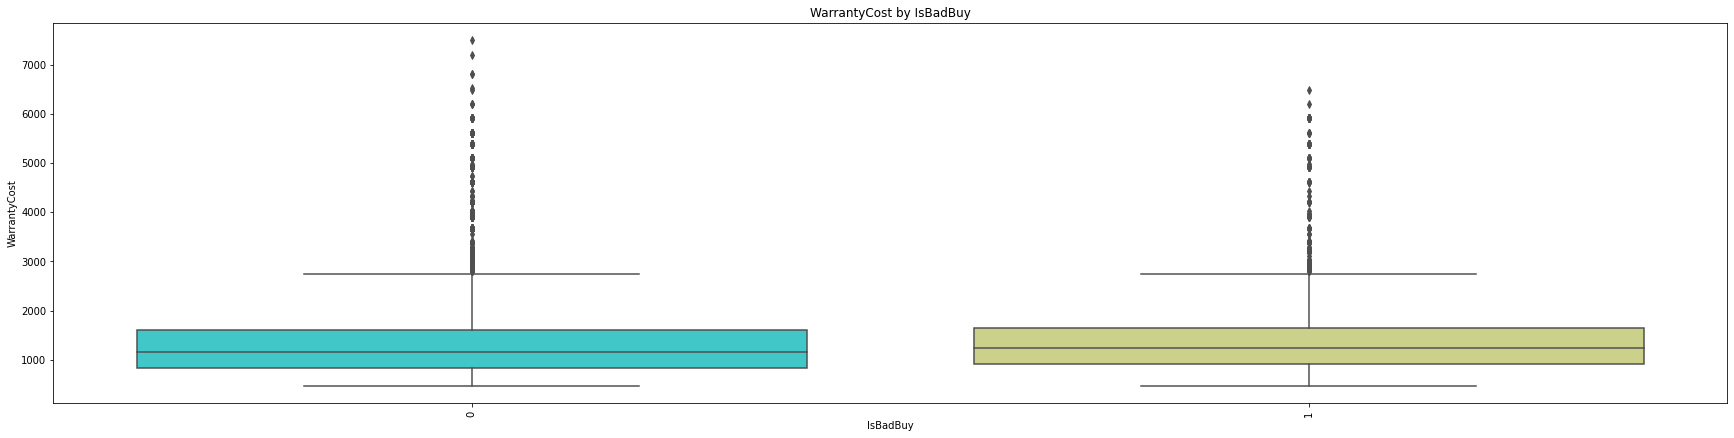

In [430]:
for feature in fact_cols.values:
    plt.figure(figsize=(30,7))
    plt.xticks(rotation='vertical')
    sns.boxplot(x='IsBadBuy',y=feature,data=df_training, palette='rainbow') #,showfliers=False)
    plt.title(feature + " by IsBadBuy")

In [431]:
df_training['SubModel'].nunique

<bound method IndexOpsMixin.nunique of 0               4D SEDAN I
1        QUAD CAB 4.7L SLT
2         4D SEDAN SXT FFV
3                 4D SEDAN
4             2D COUPE ZX3
               ...        
72978          4D SEDAN GS
72979          4D SEDAN LS
72980      4D WAGON LAREDO
72981          4D SEDAN LS
72982           4D SEDAN S
Name: SubModel, Length: 72983, dtype: object>

For dimension columns, bad buys tend to be older vehicles with more cars with wheels with covers.

In [432]:
print('--- '+dim+' ---')
print(df_training[dim].nunique())
sig_diff = df_training.loc[df_training.loc[:,'IsBadBuy'] == '0','WheelType'].value_counts(normalize=True,dropna=False) - df_training.loc[df_training.loc[:,'IsBadBuy'] == '1','WheelType'].value_counts(normalize=True,dropna=False)
print(sig_diff[(sig_diff > .01) | (sig_diff < -.01)])
print()

--- IsOnlineSale ---
2
Alloy     0.056999
Covers    0.178362
NaN      -0.234581
Name: WheelType, dtype: float64



In [433]:
for dim in dim_cols:
    print('--- '+dim+' ---')
    print(df_training[dim].nunique())
    sig_diff = abs(df_training.loc[df_training.loc[:,'IsBadBuy'] == '0',dim].value_counts(normalize=True,dropna=False) - df_training.loc[df_training.loc[:,'IsBadBuy'] == '1',dim].value_counts(normalize=True,dropna=False))
    print((sig_diff[sig_diff > .01]))
    print()

--- RefId ---
72983
Series([], Name: RefId, dtype: float64)

--- IsBadBuy ---
2
Series([], Name: IsBadBuy, dtype: float64)

--- PurchDate ---
517
Series([], Name: PurchDate, dtype: float64)

--- Auction ---
3
ADESA      0.052995
MANHEIM    0.042273
OTHER      0.010722
Name: Auction, dtype: float64

--- Make ---
33
CHEVROLET    0.055931
DODGE        0.032395
FORD         0.044668
Name: Make, dtype: float64

--- Model ---
1063
IMPALA                  0.010892
IMPALA V6               0.011257
PT CRUISER              0.018999
STRATUS V6 2.7L V6 M    0.010401
Name: Model, dtype: float64

--- Trim ---
134
NaN    0.010639
LS     0.045385
LT     0.021643
SXT    0.011741
XLT    0.012081
Name: Trim, dtype: float64

--- SubModel ---
863
4D SEDAN LS         0.027344
4D SEDAN SXT FFV    0.013154
Name: SubModel, dtype: float64

--- Color ---
16
BLACK    0.010166
BLUE     0.010614
GOLD     0.011897
Name: Color, dtype: float64

--- Transmission ---
3
Series([], Name: Transmission, dtype: float64)

---

Looking for highly correlated continuous features. VehAge is highly correlated with VehYear. MMRAcquisitonRetailCleanPrice is highly correlated with MMRQcquisitionRetailAverageprice. MMRAcquisitionAuctionCleanPrice is highly correlated with MMRAcquisitionAuctionAveragePrice, MMRCurrentRetailCleanPrice is highly correlated with MMRCurrentRetailAveragePrice, MMRCurrentAuctionCleanPrice is highly correlated with MMRCurrentAuctionAveragePrice

In [434]:
df_training[fact_cols].corr()

,VehYear,VehicleAge,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,VehBCost,WarrantyCost
VehYear,1.000000,-0.957957,-0.283719,0.581146,0.532927,0.581191,0.539230,0.590820,0.548426,0.598490,0.558669,0.349965,-0.268696
VehicleAge,-0.957957,1.000000,0.319794,-0.565690,-0.518810,-0.460854,-0.426382,-0.575607,-0.532505,-0.504062,-0.469359,-0.312329,0.259310
VehOdo,-0.283719,0.319794,1.000000,-0.017022,0.024617,0.031306,0.063165,-0.028568,0.012107,0.015811,0.048005,-0.062008,0.411718
MMRAcquisitionAuctionAveragePrice,0.581146,-0.565690,-0.017022,1.000000,0.990347,0.910391,0.910187,0.937817,0.932492,0.871755,0.871042,0.789840,-0.050417
MMRAcquisitionAuctionCleanPrice,0.532927,-0.518810,0.024617,0.990347,1.000000,0.902718,0.918242,0.923610,0.932114,0.860716,0.871203,0.781516,-0.020644
MMRAcquisitionRetailAveragePrice,0.581191,-0.460854,0.031306,0.910391,0.902718,1.000000,0.990201,0.851647,0.849407,0.913108,0.906054,0.746126,-0.053444
MMRAcquisitonRetailCleanPrice,0.539230,-0.426382,0.063165,0.910187,0.918242,0.990201,1.000000,0.846914,0.855689,0.903188,0.906810,0.744966,-0.026933
MMRCurrentAuctionAveragePrice,0.590820,-0.575607,-0.028568,0.937817,0.923610,0.851647,0.846914,1.000000,0.990329,0.915073,0.912231,0.778738,-0.056798
MMRCurrentAuctionCleanPrice,0.548426,-0.532505,0.012107,0.932492,0.932114,0.849407,0.855689,0.990329,1.000000,0.908669,0.921536,0.775100,-0.028131
MMRCurrentRetailAveragePrice,0.598490,-0.504062,0.015811,0.871755,0.860716,0.913108,0.903188,0.915073,0.908669,1.000000,0.989760,0.756816,-0.058025


## Modeling

In [435]:
df_training['RefId']

0            1
1            2
2            3
3            4
4            5
         ...  
72978    73010
72979    73011
72980    73012
72981    73013
72982    73014
Name: RefId, Length: 72983, dtype: object

In [436]:
# correlated cols to drop
unique_id_cols = ['RefId','BYRNO']
redundant_cols = ['WheelTypeID']
highly_correlated_cols = ['MMRCurrentAuctionCleanPrice','MMRCurrentRetailCleanPrice','MMRAcquisitionAuctionCleanPrice','MMRAcquisitonRetailCleanPrice','VehYear']
drop_cols = unique_id_cols + redundant_cols

# features and target cols
features = df_training.columns.copy().drop('IsBadBuy')
features = features.drop(drop_cols)
target = 'IsBadBuy'

In [437]:
features.sort_values()

Index(['AUCGUART', 'Auction', 'Color', 'IsOnlineSale',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'Make',
       'Model', 'Nationality', 'PRIMEUNIT', 'PurchDate', 'Size', 'SubModel',
       'TopThreeAmericanName', 'Transmission', 'Trim', 'VNST', 'VNZIP1',
       'VehBCost', 'VehOdo', 'VehYear', 'VehicleAge', 'WarrantyCost',
       'WheelType'],
      dtype='object')

In [438]:
fact_cols

Index(['VehYear', 'VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost'],
      dtype='object')

In [439]:
df_training.columns.sort_values()

Index(['AUCGUART', 'Auction', 'BYRNO', 'Color', 'IsBadBuy', 'IsOnlineSale',
       'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
       'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
       'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
       'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'Make',
       'Model', 'Nationality', 'PRIMEUNIT', 'PurchDate', 'RefId', 'Size',
       'SubModel', 'TopThreeAmericanName', 'Transmission', 'Trim', 'VNST',
       'VNZIP1', 'VehBCost', 'VehOdo', 'VehYear', 'VehicleAge', 'WarrantyCost',
       'WheelType', 'WheelTypeID'],
      dtype='object')

In [440]:
dim_cols_2 = dim_cols.copy().drop('IsBadBuy')

In [441]:
# label-encode categorical columns
labelencoder = {}
for col in dim_cols:
    labelencoder[col] = preprocessing.LabelEncoder()
    df_training[col] = labelencoder[col].fit_transform(df_training[col])
labelencoder_test = {}
for col in dim_cols_2:
    labelencoder_test[col] = preprocessing.LabelEncoder()
    df_test[col] = labelencoder_test[col].fit_transform(df_test[col])

In [442]:
# Scale continuous columns
scaler = preprocessing.MinMaxScaler()
scaler.fit(df_training[fact_cols]);
df_training[fact_cols]=scaler.transform(df_training[fact_cols])
df_test[fact_cols]=scaler.transform(df_test[fact_cols])


In [443]:
df_training['IsBadBuy'].unique()

array([0, 1])

In [444]:
# df_training.loc[df_training.loc[:,'IsBadBuy'] == 'nan','IsBadBuy'] = None

In [445]:
df_training.loc[df_training['IsBadBuy'].isna(),'IsBadBuy']

Series([], Name: IsBadBuy, dtype: int32)

In [446]:
X = df_training.loc[:,features]
y = df_training.loc[:,target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=25)

In [447]:
# Use Hyperparameter Optimization with Optuna

def objective(trail):

    alpha = trail.suggest_float("alpha", .0001, 1, step=.01, log=False)
    max_depth = trail.suggest_int("max_depth", 1, 10, log=False)
    reg_lambda = trail.suggest_float("reg_lambda", 0.01, 4, log=False)
    
    colsample_bytree = trail.suggest_float("colsample_bytree", 0.5, 1.0,step=.1, log=False)
    subsample = trail.suggest_float("subsample", 0.5, 1.0, step=.1, log=False)

    model  = xgb.XGBClassifier(max_depth=max_depth,learning_rate=alpha,n_estimators=200,grow_policy='depthwise',colsample_bytree=colsample_bytree,subsample=subsample,n_jobs=-1,eval_metric='error',reg_lambda=reg_lambda)
    # model  = xgb.XGBClassifier(booster='gbtree',max_depth=linear_max_depth,learning_rate=linear_alpha,n_estimators=500,grow_policy='depthwise',colsample_bytree=1,subsample=1,n_jobs=-1,eval_metric='rmse',reg_lambda=linear_reg_lambda)
    model.fit(X_train,y_train)

    # Predict on x_test
    preds = model.predict(X_test)

    error = accuracy_score(y_test, preds)
    
    return error

study = optuna.create_study(direction="maximize")  # Create a new study.
study.optimize(objective, n_trials=20)  # Invoke optimization of the objective function.

[I 2022-12-07 20:59:39,701] A new study created in memory with name: no-name-32e18138-890f-4314-876c-5a7c644151ae
C:\Users\Edward.Moradian\anaconda3\envs\DataScience\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.0001, 1] and step=0.01, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.9901].
  warnings.warn(
[I 2022-12-07 20:59:41,677] Trial 0 finished with value: 0.89586758741642 and parameters: {'alpha': 0.0601, 'max_depth': 1, 'reg_lambda': 1.3491383132184505, 'colsample_bytree': 0.9, 'subsample': 0.8}. Best is trial 0 with value: 0.89586758741642.
C:\Users\Edward.Moradian\anaconda3\envs\DataScience\lib\site-packages\optuna\distributions.py:668: UserWarning: The distribution is specified by [0.0001, 1] and step=0.01, but the range is not divisible by `step`. It will be replaced by [0.0001, 0.9901].
  warnings.warn(
[I 2022-12-07 20:59:52,668] Trial 1 finished with value: 0.8955387482187877 and parameters: {'

In [450]:
# model = xgb.XGBClassifier(use_label_encoder=False,enable_categorical=False)
model = xgb.XGBClassifier(max_depth=5,learning_rate=0.15,n_estimators=500,grow_policy='depthwise',colsample_bytree=0.5,subsample=0.7,n_jobs=-1,eval_metric='error',reg_lambda=3.1625,use_label_encoder=False,enable_categorical=False)
# 'alpha': 0.15009999999999998, 'max_depth': 5, 'reg_lambda': 3.1625543630608752, 'colsample_bytree': 0.5, 'subsample': 0.7}

In [451]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='error', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=3.1625, ...)

In [452]:
# Make predictions using the model
preds = model.predict(X_test)

In [453]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [454]:
model.classes_

array([0, 1])

In [455]:
# Check for accuracy
scores = model.score(X_train,y_train)
scores

0.9240367575862762

In [456]:
# model.score(X_test,y_test)

In [457]:
X_test['preds'] = preds

In [458]:
X_test.loc[X_test['preds']==1,:]

,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost,preds
34036,67,1,0.555556,0.333333,13,208,63,507,1,0,0,0.456543,0,3,0,0.482308,0.535690,0.488920,0.526132,0.482616,0.536341,0.554964,0.594126,2,2,111,4,0.343093,0,0.159323,1
14701,117,2,0.333333,0.555556,21,1042,82,321,13,0,3,0.669219,3,6,3,0.187140,0.208633,0.197544,0.212261,0.188539,0.220625,0.269985,0.302494,2,2,26,30,0.182524,0,0.015208,1
66715,317,0,0.666667,0.333333,29,142,53,185,13,0,3,0.604787,3,5,3,0.284671,0.301934,0.359135,0.366472,0.284671,0.301934,0.359135,0.370221,2,2,20,19,0.223762,0,0.015208,1
35705,436,1,0.222222,0.666667,4,721,7,152,2,0,1,0.645249,0,5,0,0.081462,0.101142,0.093219,0.109108,0.086893,0.103937,0.098567,0.112927,2,2,10,34,0.098949,0,0.174389,1
56041,19,2,0.111111,0.888889,5,662,7,152,13,0,0,0.674187,0,0,0,0.042999,0.058927,0.112155,0.116002,0.048206,0.065384,0.106807,0.123423,2,2,27,6,0.070357,0,0.074474,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54686,483,2,0.444444,0.444444,3,197,7,152,14,0,3,0.716896,0,0,2,0.138990,0.169104,0.150000,0.174341,0.139606,0.170867,0.150614,0.177829,2,2,87,27,0.107966,0,0.055571,1
18065,445,2,0.444444,0.555556,6,651,7,12,12,0,3,0.604453,0,10,1,0.226247,0.257522,0.285440,0.305024,0.223308,0.255813,0.298849,0.313672,2,2,118,33,0.184943,1,0.048465,1
70455,18,0,0.000000,0.888889,3,565,7,152,13,0,1,0.625942,0,5,2,0.053748,0.073659,0.065865,0.082735,0.052657,0.073876,0.064765,0.083800,2,2,103,32,0.069697,0,0.290790,1
17789,440,2,0.555556,0.333333,6,375,127,312,0,0,3,0.511831,0,0,1,0.122166,0.147427,0.133393,0.153536,0.122166,0.147427,0.133393,0.155107,2,2,118,33,0.136558,0,0.079306,1


Text(0.5, 0, 'Xgboost Feature Importance')

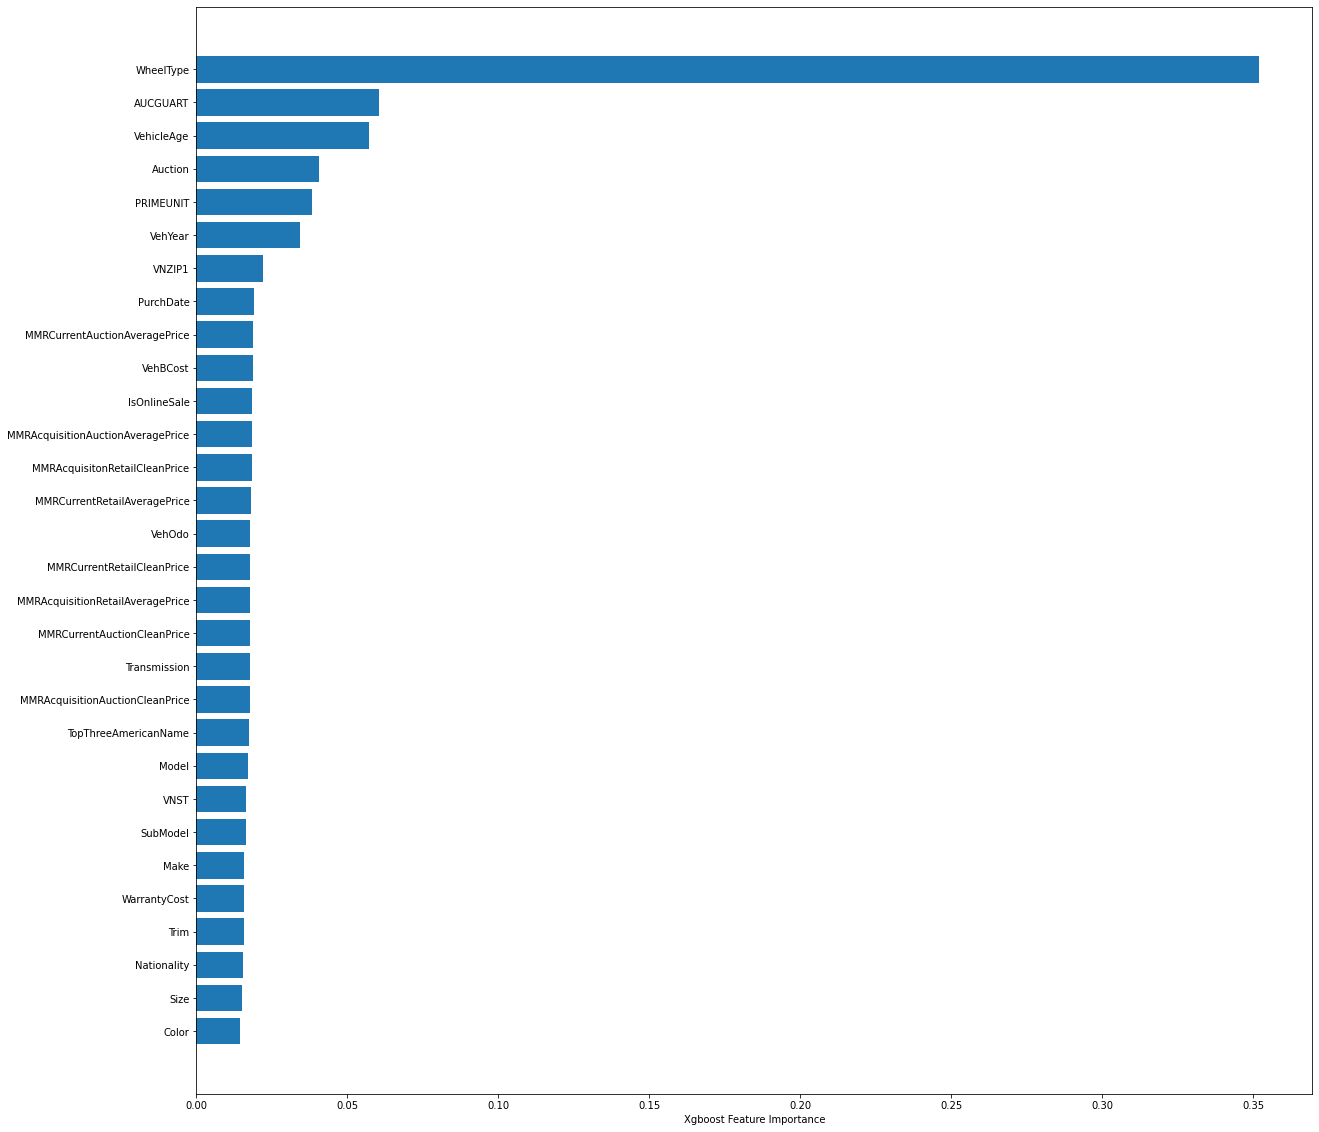

In [459]:
# display = PrecisionRecallDisplay.from_predictions(y_test, scores, name="xgb simple aggregates")
# _ = display.ax_.set_title("2-class Precision-Recall curve")

# RocCurveDisplay.from_predictions(y_test, scores, name="xgb simple aggregates")

sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize= (20,20))
plt.barh([X.columns[x] for x in sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

#### predict for submission

In [460]:
preds_test = model.predict(df_test[features])

In [461]:
preds_test

array([0, 0, 0, ..., 0, 0, 0])

In [462]:
df_submission = pd.DataFrame()

In [463]:
df_test['RefId']

0            0
1            1
2            2
3            3
4            4
         ...  
48702    48702
48703    48703
48704    48704
48705    48705
48706    48706
Name: RefId, Length: 48707, dtype: int64

In [464]:
df_test[dim_cols_2]

,RefId,PurchDate,Auction,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,Nationality,Size,TopThreeAmericanName,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,IsOnlineSale
0,0,138,0,22,389,7,135,14,0,0,0,0,2,2,2,2,43,19,6,0
1,1,138,0,3,501,53,208,14,0,0,0,0,5,2,2,2,40,19,6,0
2,2,138,0,5,219,6,368,14,0,0,0,0,6,0,2,2,40,19,6,0
3,3,138,0,23,453,50,199,4,0,0,0,0,5,2,2,2,43,19,6,0
4,4,138,0,9,29,33,24,2,0,3,3,2,0,3,2,2,40,19,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48702,48702,94,1,6,320,80,247,1,0,0,0,0,2,1,2,2,53,32,5,0
48703,48703,94,1,27,197,9,160,5,0,1,1,3,0,3,2,2,53,32,5,0
48704,48704,94,1,13,770,23,172,1,0,1,1,2,5,3,0,0,53,32,5,0
48705,48705,94,1,16,520,127,185,14,0,0,0,2,5,3,0,0,53,32,5,0


In [465]:
dim_cols_2

Index(['RefId', 'PurchDate', 'Auction', 'Make', 'Model', 'Trim', 'SubModel',
       'Color', 'Transmission', 'WheelTypeID', 'WheelType', 'Nationality',
       'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'BYRNO',
       'VNZIP1', 'VNST', 'IsOnlineSale'],
      dtype='object')

In [466]:
for col in dim_cols_2:
    df_test[col] = labelencoder_test[col].inverse_transform(df_test[col])

In [467]:
df_submission['RefId'] = df_test['RefId']

In [468]:
df_submission['IsBadBuy'] = preds_test

In [469]:
df_submission

,RefId,IsBadBuy
0,73015,0
1,73016,0
2,73017,0
3,73018,0
4,73019,1
...,...,...
48702,121742,0
48703,121743,0
48704,121744,0
48705,121745,0


In [470]:
df_submission.to_csv('C:/Users/Edward.Moradian/OneDrive - Microsoft/Desktop/Home/github/kaggle/dont get kicked/df_submission.csv',index=False)